# **Final Project**

For our final project we try to forecast stock price on a given day from a sequence from previous days data.

We will try several models, starting from a simple LSTM adapted from our Lab 2 work.  With some modifications:

* Removing the last linear layer activation function as we are going to do a forecast and not a classification.

* Reshaping the output dimensions so that we can predict as many features as we like.

* Changing the loss function into a MSE lost.


In [156]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.modules import activation
import torch
from torch import nn
import torch.optim as optim

In [157]:
drive.mount('/content/drive')
myDrive = '/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/Mixed_ETF/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
file_path = os.path.join(myDrive,'ETF_Data.csv')
data = pd.read_csv(file_path, sep=",", header=0)

Split Data

In [159]:
data.head()

,Date_vaw,Open_vaw,High_vaw,Low_vaw,Close_vaw,Volume_vaw,Open_vcr,High_vcr,Low_vcr,Close_vcr,...,Open_vht,High_vht,Low_vht,Close_vht,Volume_vht,Open_vnq,High_vnq,Low_vnq,Close_vnq,Volume_vnq
0,2005-02-25,54.737,55.614,54.737,55.594,20156,49.021,49.292,49.021,49.255,...,46.707,47.021,46.602,47.021,122102,39.719,40.308,39.719,40.272,39871
1,2005-02-28,55.728,55.728,54.855,55.194,47699,49.274,49.274,49.021,49.183,...,46.800,46.800,46.207,46.476,13375,40.301,40.401,39.749,40.156,72024
2,2005-03-01,55.418,55.640,55.041,55.130,17578,49.403,49.653,49.403,49.653,...,46.622,46.791,46.622,46.753,46598,40.079,40.577,40.079,40.577,45622
3,2005-03-02,54.649,55.263,54.649,55.085,11532,49.589,49.969,49.589,49.784,...,46.587,47.049,46.587,46.791,160287,40.308,40.499,40.207,40.308,20521
4,2005-03-03,55.409,55.409,54.855,55.122,28440,49.822,49.822,49.543,49.755,...,46.883,46.910,46.641,46.724,29446,40.308,40.569,40.224,40.522,12941


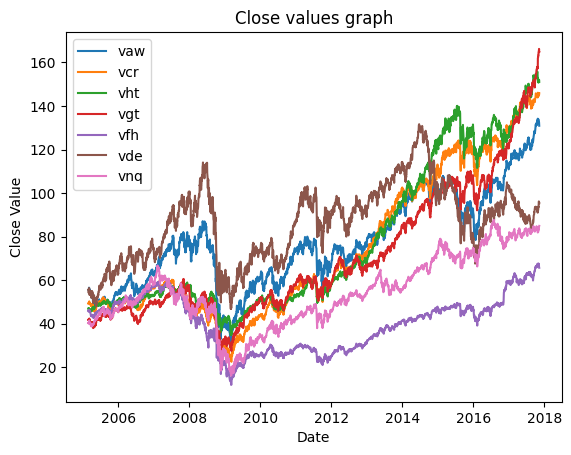

In [160]:
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vaw'], label='vaw')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vcr'], label='vcr')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vht'], label='vht')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vgt'], label='vgt')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vfh'], label='vfh')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vde'], label='vde')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vnq'], label='vnq')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Close values graph')
plt.legend()
plt.show()

In [161]:
data.rename(columns={'Date_vaw': 'Date'}, inplace=True)
data.index = data['Date']
data.pop('Date')
Train = data[:2560]
Test = data[2560:]
print(Train.shape)
print(Test.shape)
print(len(Test))

(2560, 35)
(641, 35)
641


In [162]:
import numpy as np

# Compute mean and std across samples and time steps for each feature
mean = np.mean(Train, axis=(0))
std = np.std(Train, axis=(0))
std[std == 0] = 1  # Prevent division by zero

# Normalize training data
Train_normalized = (Train - mean) / std

# Normalize test data
# Assuming you have test data: X_test, Y_test
Test_normalized = (Test - mean) / std

In [163]:
mode_list = ['multi', 'single']
ETF = ['vaw', 'vcr', 'vgt', 'vfh', 'vde', ' vht', 'vnq']

In [164]:
mode = 'multi'
ETF_active = ETF[0];
fragment_size = 10;
step = 1

if (mode == mode_list[0]):
  Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size] for i in range(0, len(Train_normalized) - fragment_size, step)]
  Train_Labels = [Train_normalized.iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Train_normalized), step)]

  Test_Fragmented = [Test_normalized .iloc[i:i + fragment_size] for i in range(0, len(Test_normalized ) - fragment_size, step)]
  Test_Labels = [Test_normalized .iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Test_normalized ), step)]
else:
  Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Train_normalized) - fragment_size, step)]
  Train_Labels = [Train_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Train_normalized), step)]

  Test_Fragmented = [Test.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Test_normalized ) - fragment_size, step)]
  Test_Labels = [Test.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Test_normalized ), step)]


In [165]:
# Print dimensions for verification
print(f'Number of Train Fragments: {len(Train_Fragmented)}')
print(f'Number of Train Labels: {len(Train_Labels)}')
print(f'Number of Test Fragments: {len(Test_Fragmented)}')
print(f'Number of Test Labels: {len(Test_Labels)}')


Number of Train Fragments: 2550
Number of Train Labels: 2550
Number of Test Fragments: 631
Number of Test Labels: 631


In [166]:
#Print start and end of training and test data for verification
print(f'\nTraining data\n')
print(Train_Fragmented[1]['Close_' + ETF_active])
print(Train_Labels[1])
print(Train_Fragmented[2]['Close_' + ETF_active])
print(Train_Labels[2])

print(Train_Fragmented[2548]['Close_' + ETF_active])
print(Train_Labels[2548])
print(Train_Fragmented[2549]['Close_' + ETF_active])
print(Train_Labels[2549])

print(f'\nTest data\n')
print(Test_Fragmented[0]['Close_' + ETF_active])
print(Test_Labels[0])
print(Test_Fragmented[1]['Close_' + ETF_active])
print(Test_Labels[1])

print(Test_Fragmented[629]['Close_' + ETF_active])
print(Test_Labels[629])
print(Test_Fragmented[630]['Close_' + ETF_active])
print(Test_Labels[630])


Training data

Date
2005-02-28   -0.906491
2005-03-01   -0.910282
2005-03-02   -0.912947
2005-03-03   -0.910756
2005-03-04   -0.823515
2005-03-07   -0.847857
2005-03-08   -0.862604
2005-03-09   -0.864085
2005-03-10   -0.911822
2005-03-11   -0.887539
Name: Close_vaw, dtype: float64
Close_vaw   -0.894942
Close_vcr   -0.542463
Close_vgt   -0.965319
Close_vfh    0.735077
Close_vde   -1.652162
Close_vht   -0.750104
Close_vnq   -0.677831
Name: 2005-03-14, dtype: float64
Date
2005-03-01   -0.910282
2005-03-02   -0.912947
2005-03-03   -0.910756
2005-03-04   -0.823515
2005-03-07   -0.847857
2005-03-08   -0.862604
2005-03-09   -0.864085
2005-03-10   -0.911822
2005-03-11   -0.887539
2005-03-14   -0.894942
Name: Close_vaw, dtype: float64
Close_vaw   -0.903293
Close_vcr   -0.532480
Close_vgt   -0.984028
Close_vfh    0.728375
Close_vde   -1.691771
Close_vht   -0.771310
Close_vnq   -0.681605
Name: 2005-03-15, dtype: float64
Date
2015-04-14    2.004853
2015-04-15    2.059934
2015-04-16    2.035651
20

Date
2015-05-07    2.096062
2015-05-08    2.180756
2015-05-11    2.158250
2015-05-12    2.097839
2015-05-13    2.100208
2015-05-14    2.171872
2015-05-15    2.184902
2015-05-18    2.178979
2015-05-19    2.145812
2015-05-20    2.142851
Name: Close_vaw, dtype: float64
Date
2015-05-08    2.180756
2015-05-11    2.158250
2015-05-12    2.097839
2015-05-13    2.100208
2015-05-14    2.171872
2015-05-15    2.184902
2015-05-18    2.178979
2015-05-19    2.145812
2015-05-20    2.142851
2015-05-21    2.162396
Name: Close_vaw, dtype: float64


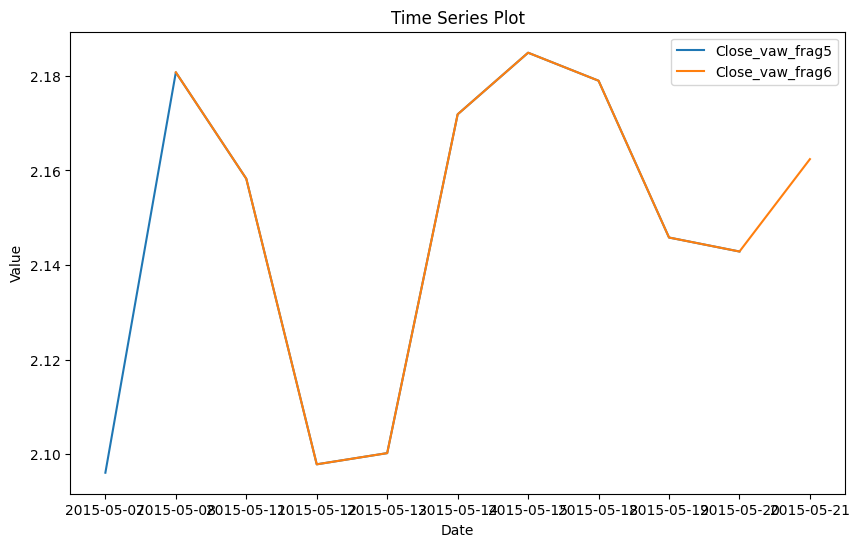

In [167]:
print(Test_Fragmented[5]['Close_' + ETF_active])
print(Test_Fragmented[6]['Close_' + ETF_active])
# Plot the time series data using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(Test_Fragmented[5].index, Test_Fragmented[5]['Close_' + ETF_active], label='Close_'  + ETF_active + '_frag5')
plt.plot(Test_Fragmented[6].index, Test_Fragmented[6]['Close_' + ETF_active], label='Close_'  + ETF_active + '_frag6')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

In [168]:
# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters
class Simple_LSTM(nn.Module):
  def __init__(self,
               input_size : int = 5,
               hidden_size : int = 64,
               output_size : int = 1,
               num_layers : int =  5,
               activation_function = nn.Softmax(dim = 1)):  #softmax activation function in order to get multiclass probability
    # Define RNN or LSTM architecture
    super().__init__()
    self.rnn =  nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                          num_layers=num_layers, batch_first = True)

    self.activation_function = activation_function

    self.last_linear = nn.Linear(hidden_size,output_size)

  def forward(self, X):
    _,last_states = self.rnn(X)
    # Get last hidden state for last layer. Ignore cell state in case of LSTMs
    last_hidden_state = last_states[0][-1, :, :]
    # Get sequence label probability using the last hidden state
    next_prediction = self.last_linear(last_hidden_state)
    return next_prediction


In [169]:
def train_simple_LSTM(X_train, Y_train, model, optimizer, loss_func, epochs=100):
    loss_its = []
    for iter in range(epochs):
      optimizer.zero_grad()
      output = model(X_train)
      loss = loss_func(output,Y_train)
      loss_its.append(loss.item())
      loss.backward()
      optimizer.step()
    print(f'Final loss: {loss.item()}')
    return np.asarray(loss_its)

In [170]:
tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Fragmented]
X_train = torch.stack(tensor_list)
label_tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Labels]
Y_train =  torch.stack(label_tensor_list)

tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Fragmented]
X_test = torch.stack(tensor_list_test)
label_tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Labels]
Y_test =  torch.stack(label_tensor_list_test)

In [171]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming X_train, Y_train, X_test, Y_test are already defined and normalized
X_train_pt = X_train.float().to(device)
Y_train_pt = Y_train.float().to(device)
X_test_pt = X_test.float().to(device)
Y_test_pt = Y_test.float().to(device)

train_dataset = torch.utils.data.TensorDataset(X_train_pt, Y_train_pt)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

print(X_train.shape)
print(Y_train.shape)

torch.Size([2550, 10, 35])
torch.Size([2550, 7])


In [172]:
if (mode == mode_list[0]):
  input_size = 35
  hidden_size = 256
  num_layers = 2
  output_size = 7
  num_epochs = 4000
else:
  input_size = 5
  hidden_size = 64
  num_layers = 2
  output_size = 1
  num_epochs = 4000

# Define model, loss function, and optimizer
model = Simple_LSTM(input_size=input_size, hidden_size=hidden_size, output_size = output_size, num_layers=num_layers).cuda()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)

'''# Training loop
num_epochs = 4000
loss_its = []
for iter in range(num_epochs):
  optimizer.zero_grad()
  output = model(X_train_pt)
  loss = loss_func(output,Y_train_pt)
  loss_its.append(loss.item())
  loss.backward()
  optimizer.step()

  if( iter%100 == 0):
    print(f'Final loss: {loss.item()}')

#loss_history = train_simple_LSTM(X_train_pt, Y_train_pt, model, optimizer, loss_func, epochs=num_epochs)'''


"# Training loop\nnum_epochs = 4000\nloss_its = []\nfor iter in range(num_epochs):\n  optimizer.zero_grad()\n  output = model(X_train_pt)\n  loss = loss_func(output,Y_train_pt)\n  loss_its.append(loss.item())\n  loss.backward()\n  optimizer.step()\n\n  if( iter%100 == 0):\n    print(f'Final loss: {loss.item()}')\n\n#loss_history = train_simple_LSTM(X_train_pt, Y_train_pt, model, optimizer, loss_func, epochs=num_epochs)"

In [185]:
# Training loop
num_epochs = 100
loss_its = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    # Iterate over batches in the DataLoader
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()

        # Move batch data to the device
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        # Forward pass
        output = model(batch_X)

        # Compute loss
        loss = loss_func(output, batch_Y)
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Compute average loss for the epoch
    epoch_loss /= len(train_loader)
    loss_its.append(epoch_loss)

    # Print epoch statistics
    if epoch % 5 == 0:
        output_test = model(X_test_pt)
        test_loss = loss_func(output_test, Y_test_pt)
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss},Test_loss: {test_loss}')

print('Training complete.')


Epoch [0/100], Loss: 0.004745504475431516,Test_loss: 0.42719703912734985
Epoch [5/100], Loss: 0.0043565409258008005,Test_loss: 0.4450780153274536
Epoch [10/100], Loss: 0.0038046360888984053,Test_loss: 0.43645113706588745
Epoch [15/100], Loss: 0.003673314361367375,Test_loss: 0.428396075963974
Epoch [20/100], Loss: 0.003285108384443447,Test_loss: 0.432545930147171
Epoch [25/100], Loss: 0.003145840170327574,Test_loss: 0.43120861053466797
Epoch [30/100], Loss: 0.0030026664928300304,Test_loss: 0.42875832319259644
Epoch [35/100], Loss: 0.002903901087120175,Test_loss: 0.4283454418182373
Epoch [40/100], Loss: 0.0027526856487384067,Test_loss: 0.43022963404655457
Epoch [45/100], Loss: 0.0027398174250265585,Test_loss: 0.425022155046463
Epoch [50/100], Loss: 0.002529352140845731,Test_loss: 0.40462926030158997
Epoch [55/100], Loss: 0.002393067319644615,Test_loss: 0.42225268483161926
Epoch [60/100], Loss: 0.002300940759596415,Test_loss: 0.44008979201316833
Epoch [65/100], Loss: 0.00215151873708237,T

# Histogram

In [174]:
print(X_train_pt.shape)
print(Y_train_pt.shape)

torch.Size([2550, 10, 35])
torch.Size([2550, 7])


In [175]:
print(X_test_pt.shape)

Y_predicted = model(X_train_pt).cpu().detach().numpy()
print(Y_test_pt.shape)


torch.Size([631, 10, 35])
torch.Size([631, 7])


In [176]:
Y_predicted = model(X_train_pt).cpu().detach().numpy()
print(Y_predicted)

[[-1.3102257  -0.69412863 -0.9830203  ... -1.5303195  -0.66983485
  -0.39638346]
 [-1.313915   -0.69664836 -0.9852897  ... -1.5341752  -0.6710218
  -0.40054965]
 [-1.319257   -0.699337   -0.98844707 ... -1.5399597  -0.672579
  -0.40607804]
 ...
 [ 2.0435553   2.2755854   2.4514515  ...  1.4146976   3.007229
   1.9823695 ]
 [ 2.0474737   2.2887928   2.4716396  ...  1.4123206   3.0266914
   1.9990609 ]
 [ 2.041376    2.287572    2.4708982  ...  1.4055148   3.0291524
   2.0047855 ]]


In [186]:
#Print Train
Y_predicted_train = model(X_train_pt).cpu().detach().numpy()
print(Y_predicted)

if (mode == mode_list[0]):
  Y_train = Train_normalized[fragment_size:][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
else:
  Y = Train_normalized[fragment_size:][['Close_'  + ETF_active]]
Y_train = Y_train.to_numpy()

#Print Test
Y_predicted_test = model(X_test_pt).cpu().detach().numpy()
print(Y_predicted)

if (mode == mode_list[0]):
  Y_test = Test_normalized[fragment_size:][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
else:
  Y_test = Test_normalized[fragment_size:][['Close_'  + ETF_active]]
Y_test = Y_test.to_numpy()

[[2.0364985 2.2670403 2.4342573 ... 1.4177378 2.9802258 1.9499018]
 [2.0379076 2.2683868 2.4355235 ... 1.4190603 2.9813368 1.9519391]
 [2.038136  2.2682045 2.4353526 ... 1.4186677 2.982365  1.9537877]
 ...
 [2.1776993 2.452276  2.6866438 ... 1.379506  3.2851436 2.2310443]
 [2.1781301 2.4512339 2.6850564 ... 1.3800564 3.2832239 2.2298396]
 [2.1769214 2.4526446 2.6882517 ... 1.3780656 3.2881634 2.2319221]]
[[2.0364985 2.2670403 2.4342573 ... 1.4177378 2.9802258 1.9499018]
 [2.0379076 2.2683868 2.4355235 ... 1.4190603 2.9813368 1.9519391]
 [2.038136  2.2682045 2.4353526 ... 1.4186677 2.982365  1.9537877]
 ...
 [2.1776993 2.452276  2.6866438 ... 1.379506  3.2851436 2.2310443]
 [2.1781301 2.4512339 2.6850564 ... 1.3800564 3.2832239 2.2298396]
 [2.1769214 2.4526446 2.6882517 ... 1.3780656 3.2881634 2.2319221]]


In [178]:
file_path = os.path.join(myDrive,'Y_predicted.csv')
pd.DataFrame(Y_predicted).to_csv(file_path, index=False)

In [187]:
import matplotlib.pyplot as plt

# Example arrays for Y_predicted and Y
# Ensure these are defined as per your actual data
# Y_predicted = np.random.randn(640, 6)  # Example: If Y_predicted is a 2D array
# Y = np.random.randn(640, 6, 1)  # Example: If Y is a 3D array

def plot_results(Y_squeezed, Y_predicted, title = 'Test sample forecast of vaw'):
    # Check the shapes (for debugging purposes)
    print("Y_predicted shape:", Y_predicted.shape)
    print("Y shape after squeezing:", Y_squeezed.shape)

    # Plot the actual signals
    plt.figure(figsize=(12, 8))
    if Y_squeezed.ndim == 2:
      for i in range(1):#Y_squeezed.shape[1]):
          plt.plot(Y_squeezed[:, i], label=f"Actual Signal {i+1}")
    else:
      plt.plot(Y_squeezed[:], label=f"Actual Signal {1}")

    # Ensure Y_predicted is compatible for plotting
    if Y_predicted.shape[1] == 1:
        # If Y_predicted is 1D, we plot it directly
        plt.plot(Y_predicted, label="Predicted Signal", linestyle='--')
    elif Y_predicted.ndim == 2 and Y_predicted.shape[1] == Y_squeezed.shape[1]:
        # If Y_predicted is 2D, plot each predicted signal
        for i in range(1):#Y_predicted.shape[1]):
            plt.plot(Y_predicted[:, i], linestyle='--', label=f"Predicted Signal {i+1}")

    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

Y_predicted shape: (2550, 7)
Y shape after squeezing: (2550, 7)


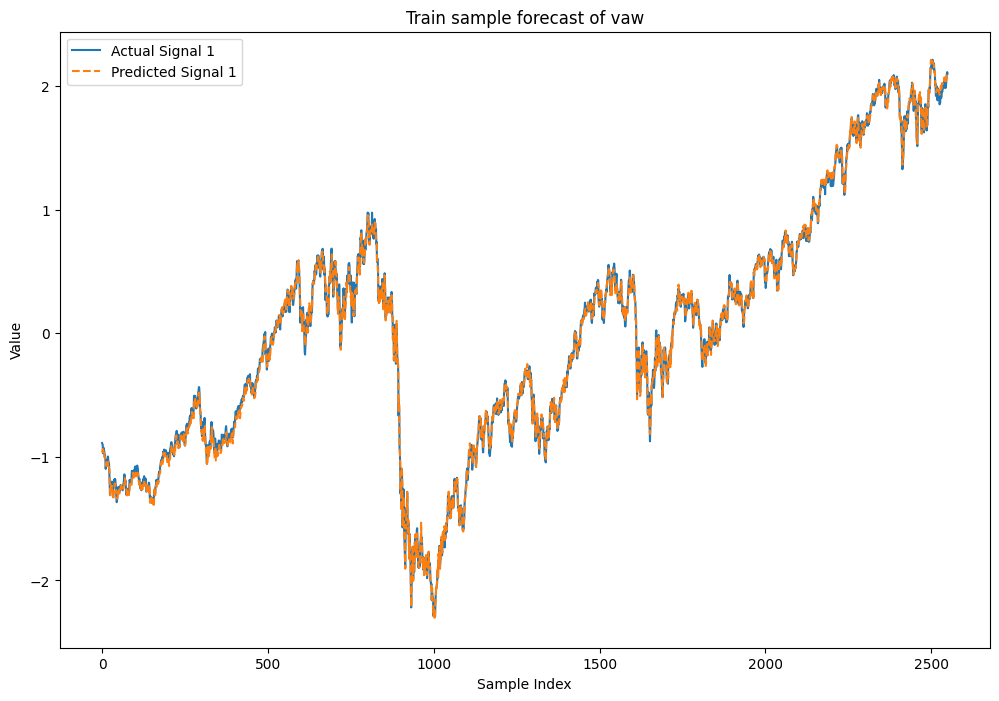

In [188]:

# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y_train.squeeze()
Y_predicted = Y_predicted_train
plot_results(Y_squeezed, Y_predicted, 'Train sample forecast of vaw')

Y_predicted shape: (631, 7)
Y shape after squeezing: (631, 7)


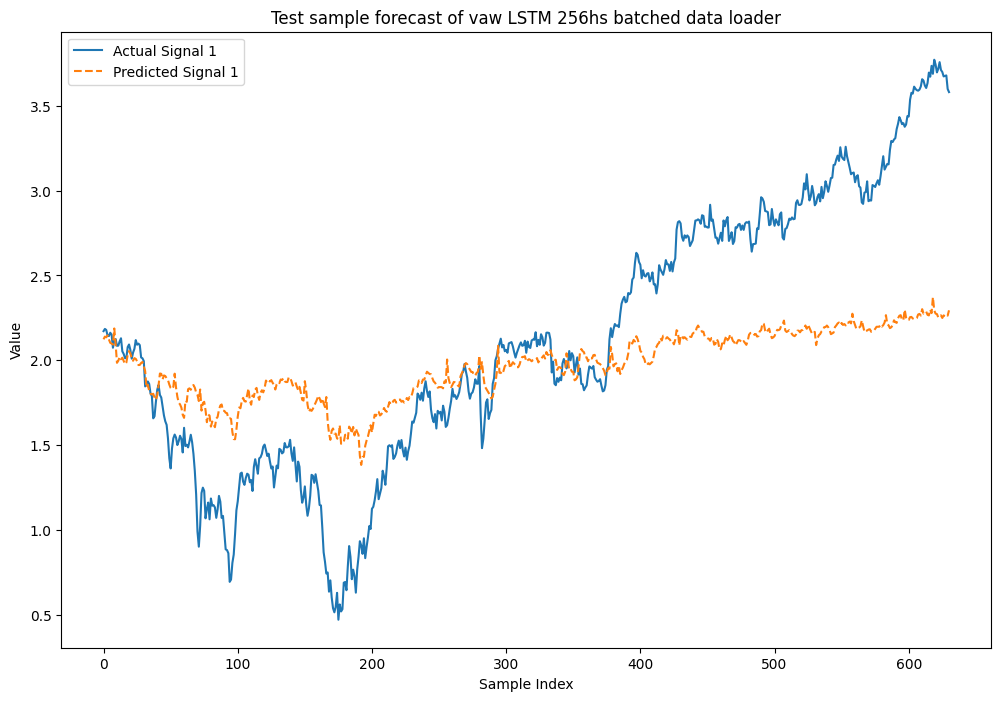

In [189]:
# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y_test.squeeze()
Y_predicted = Y_predicted_test
plot_results(Y_squeezed, Y_predicted, 'Test sample forecast of vaw LSTM 256hs batched data loader')

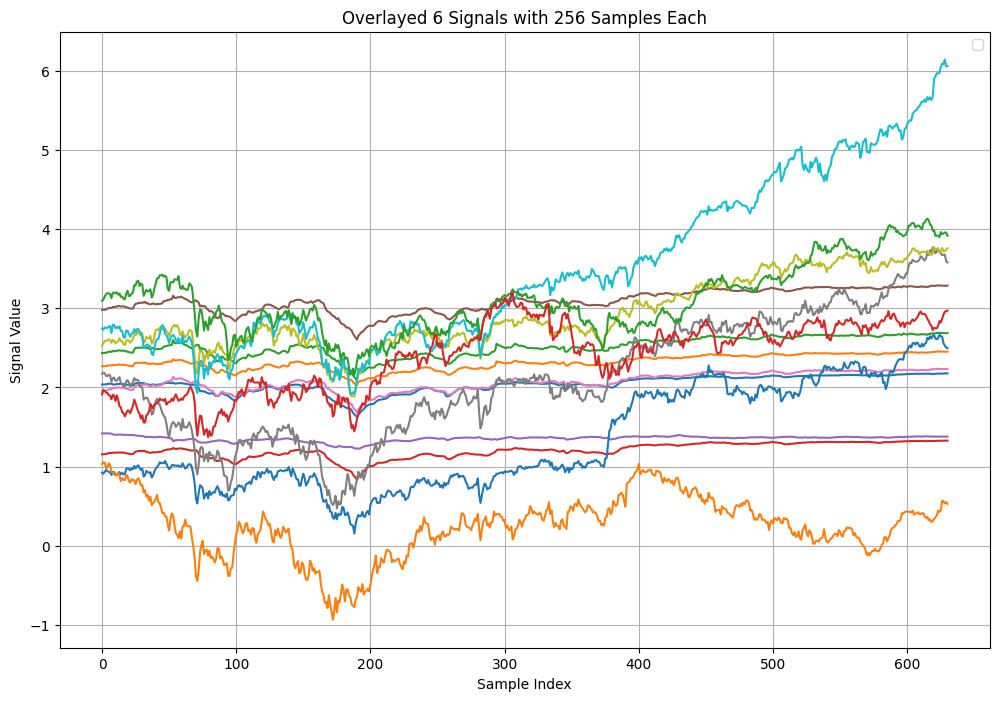

In [182]:
plt.figure(figsize=(12, 8))
plt.plot(Y_predicted)
plt.plot(Y)
plt.title('Overlayed 6 Signals with 256 Samples Each')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.show()